In [1]:
import sys
sys.path.append('../')
from CGD import AA_model, AA_trainer
from scipy.spatial import ConvexHull
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils.AA_visualize import plot_AA, plot_AA_simple, plot_AA_reconstructed, plot_AA_reconstructed_angle

# Toy data

In [3]:
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 20

var = 0.2
rad = (np.cos(30/(180/np.pi))*3)
X1 = np.random.multivariate_normal([0,0],[[var,0],[0,var]],n).T
X2 = np.random.multivariate_normal([1.5,rad],[[var,0],[0,var]],n).T
X3 = np.random.multivariate_normal([-1.5,rad],[[var,0],[0,var]],n).T

X = np.concatenate((X1,X2,X3),axis=1)

data = torch.tensor(X).to(device)

labels = np.concatenate((np.zeros(n),np.ones(n),2*np.ones(n))).astype(int)

K = 3
model = AA_model.AA(X=data,num_comp=K,model='AA')
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss,_ = AA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=10000,tol=1e-6)

C, S = model.get_model_params()  # C, S is numpy array

Device:  cuda


 25%|██▌       | 2545/10000 [00:06<00:18, 404.69it/s]

Tolerance reached at 2546 number of iterations


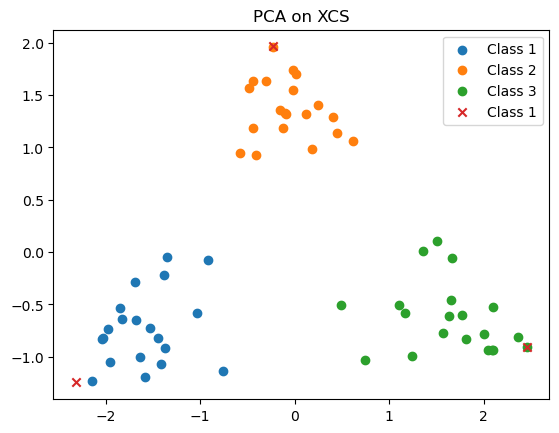

In [4]:
# Do PCA on XCS
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
XCS = X @ C @ S
XC = X @ C
XCS_pca = pca.fit_transform(XCS.T)
XC_pca = pca.transform(XC.T)

plt.figure()
plt.scatter(XCS_pca[:n,0],XCS_pca[:n,1],label='Class 1')
plt.scatter(XCS_pca[n:2*n,0],XCS_pca[n:2*n,1],label='Class 2')
plt.scatter(XCS_pca[2*n:,0],XCS_pca[2*n:,1],label='Class 3')
# plot XC
plt.scatter(XC_pca[:n,0],XC_pca[:n,1],label='Class 1',marker='x')
plt.legend()
plt.title('PCA on XCS')
plt.show()

In [5]:
XC_pca

array([[-0.22535203,  1.96437636],
       [ 2.45948749, -0.91161028],
       [-2.31290199, -1.24649792]])

In [6]:
# use the angle to determine the order of the points [0,2pi]
angles = (np.arctan2(XC_pca[:,1],XC_pca[:,0]) + 2*np.pi) % (2*np.pi)
angles

array([1.68501638, 5.92823333, 3.63589901])

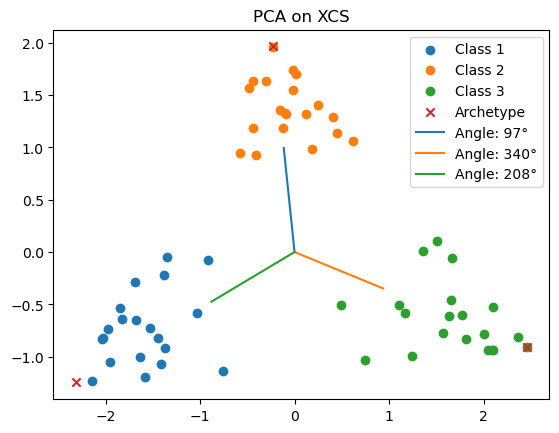

In [7]:
# Draw a line at that angle
plt.figure()
plt.scatter(XCS_pca[:n,0],XCS_pca[:n,1],label='Class 1')
plt.scatter(XCS_pca[n:2*n,0],XCS_pca[n:2*n,1],label='Class 2')
plt.scatter(XCS_pca[2*n:,0],XCS_pca[2*n:,1],label='Class 3')
# plot XC
plt.scatter(XC_pca[:,0],XC_pca[:,1],label='Archetype', marker='x')
# Draw all the lines using the angles
angles_sorted = angles[np.argsort(angles)]
for angle in angles:
    x_end = np.cos(angle)
    y_end = np.sin(angle)
    plt.plot([0, x_end], [0, y_end], label=f'Angle: {np.degrees(angle):.0f}°')
plt.legend()
plt.title('PCA on XCS')
plt.show()

In [8]:
XC_pca[:,0]

array([-0.22535203,  2.45948749, -2.31290199])

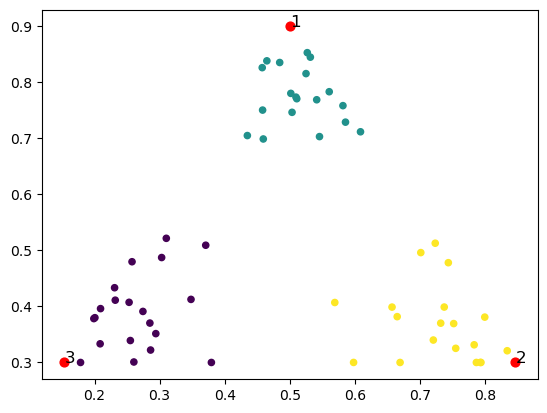

In [9]:
plot_AA_reconstructed_angle(X, C, S, K, y=labels, point_size=20)